In [1]:
# The aim of this notebook is to produce summary statistics for Hazards over a range of areas
# typical statistic include, median, min, max, 10th, 90th percentiles

In [ ]:
# example data /g/data/ia39/ncra/extratropical_storms

In [2]:
# https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb

In [3]:
import calendar

import xarray as xr
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np

In [ ]:
from glob import glob 
from datetime import datetime

from dask.distributed import Client
ncpus = os.environ.get('PBS_NCPUS')
client = Client(n_workers=int(ncpus))
client

In [5]:
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NRM, etc
gdf_dict = {}

shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]
for name in shape_files:
    gdf_dict.update({name: gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')})
gdf_dict.update({"broadacre_regions" : gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp')})

In [6]:
crs = ccrs.LambertConformal(central_latitude = -24.75, central_longitude = 134.0,cutoff=30, standard_parallels=(-10,-40))


In [7]:
filelist = glob("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/CSIRO/ACCESS-CM2/ssp126/r4i1p1f1/CCAM-v2203-SN/v1-r1/day/tasmax/*")

# filelist = glob("/g/data/lp01/CORDEX-CMIP6/CMIP6/DD/gr1.5/CSIRO/ACCESS-CM2/ssp126/r4i1p1f1/CCAM-v2203-SN/v1-r1/mon/tas/v20231206/tas_gr1.5_ACCESS-CM2_ssp126_r4i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_mon_201501-209912.nc")

In [8]:
ds = xr.open_mfdataset(filelist,
                      # preprocess= lambda ds: ds.resample(time = "1YE").mean(),
                      use_cftime = True,
                       parallel=True,
                      chunks = {"time":"200MB"})

In [9]:
states_gdf = gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')
states_gdf = states_gdf[:-2] # exclude ACT and other territories 


In [10]:
states_regions = regionmask.from_geopandas(
    states_gdf,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states"
)

### states_regions

In [11]:
# for default mask if only concerned in centre is within mask
mask_centre = states_regions.mask_3D(ds)





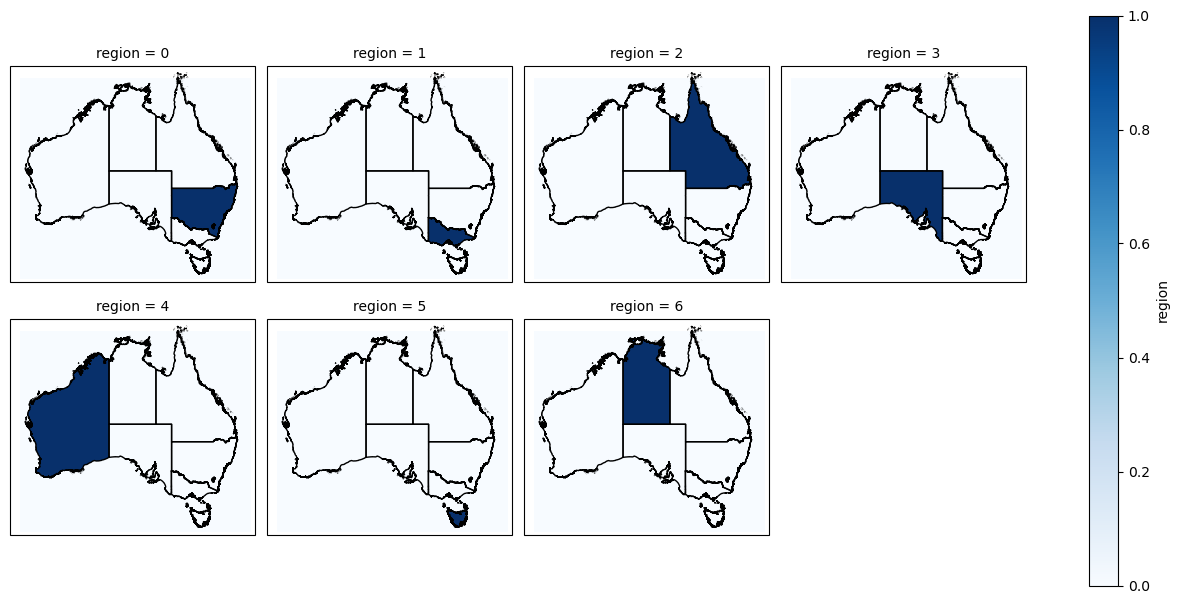

In [12]:
# fractional mask is more memory intensive and more relevant for coarse resolution data
frac = states_regions.mask_3D_frac_approx(ds)

fg = frac.plot(
    subplot_kws=dict(projection=crs),
    col="region",
    col_wrap=4,
    transform=crs,
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.set_extent([110, 157, -8, -45], crs=crs)
    gdf_dict["aus_states_territories"].plot(ax=ax, facecolor="none", edgecolor="black",)
plt.show()

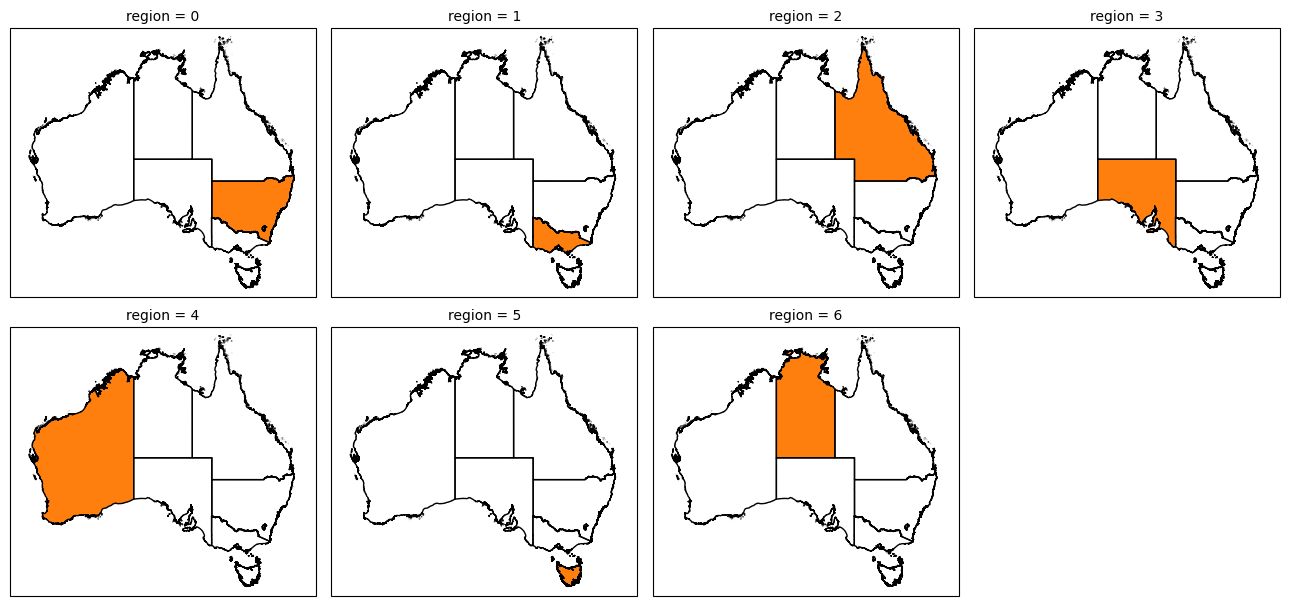

In [13]:
fg = mask_centre.plot(
    subplot_kws=dict(projection=crs),
    col="region",
    col_wrap=4,
    transform=crs,
    add_colorbar=False,
    cmap=mplc.ListedColormap(["none", "tab:orange"]),
)
for ax in fg.axs.flatten():
    ax.set_extent([110, 157, -8, -45], crs=crs)
    gdf_dict["aus_states_territories"].plot(ax=ax, facecolor="none", edgecolor="black",)
fg.fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

In [14]:
qld_mask = mask_centre.isel(region = (mask_centre.names == "Queensland"))


In [15]:
ds_qld = ds.where(qld_mask)#.mean(dim=["lon", "lat"])
ds_qld


<xarray.Dataset> Size: 2GB
Dimensions:   (time: 85, lat: 691, lon: 886, region: 1, bnds: 2)
Coordinates:
  * lat       (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * time      (time) object 680B 2015-12-31 00:00:00 ... 2099-12-31 00:00:00
  * region    (region) int64 8B 2
    abbrevs   (region) <U3 12B 'QLD'
    names     (region) <U18 72B 'Queensland'
Dimensions without coordinates: bnds
Data variables:
    tasmax    (time, lat, lon, region) float32 208MB dask.array<chunksize=(1, 691, 886, 1), meta=np.ndarray>
    lat_bnds  (time, lat, bnds, region, lon) float64 833MB dask.array<chunksize=(1, 691, 2, 1, 886), meta=np.ndarray>
    lon_bnds  (time, lon, bnds, region, lat) float64 833MB dask.array<chunksize=(1, 886, 2, 1, 691), meta=np.ndarray>
Attributes: (12/28)
    Conventions:             CF-1.10
    activity_id:             DD
    contact:                 ccam@csiro.au
    domain:                  Australia/AGCD
    domain_id:               AGCD-05i
    driving_experiment:      update of RCP2.6 based on SSP1
    ...                      ...
    variable_id:             tasmax
    input_tracking_id:       e85f5604-acda-4b0b-9155-912f71b77af2
    input_doi:               https://doi.org/10.25914/rd73-4m38
    title:                   Pre-processed model output in preparation for bi...
    history:                 Fri Apr 12 08:53:07 2024: ncatted -O -a least_si...
    NCO:                     netCDF Operators version 5.0.5 (Homepage = http:...

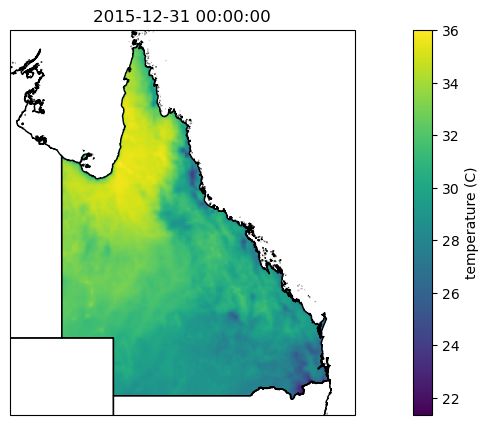

In [16]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=crs)
ds_qld['tasmax'].isel(time=0).plot(
    ax=ax,
    transform=crs,
    cbar_kwargs={'label': f'temperature (C)'},
)
ax.set_extent([135, 155, -10, -30], crs=crs )
ax.set_title(ds_qld['tasmax'].isel(time=0)["time"].values)
gdf_dict["aus_states_territories"].plot(ax=ax, facecolor="none", edgecolor="black",)

plt.show()

In [29]:
weights = np.cos(np.deg2rad(ds['lat']))
spatial_means = ds['tasmax'].weighted(frac * weights).mean(dim=("lat", "lon"))
spatial_means

<xarray.DataArray 'tasmax' (time: 31046, region: 7)> Size: 2MB
dask.array<truediv, shape=(31046, 7), dtype=float64, chunksize=(85, 7), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 248kB 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * region   (region) int64 56B 0 1 2 3 4 5 6
    abbrevs  (region) <U3 84B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT'
    names    (region) <U18 504B 'New South Wales' ... 'Northern Territory'

In [28]:
ds = ds.chunk({'time': 85})

CPU times: user 13min 50s, sys: 2min 21s, total: 16min 12s
Wall time: 9min 28s


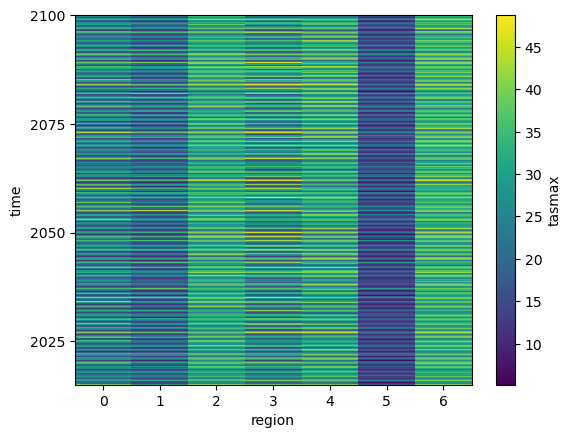

In [31]:
%%time
# with chnuked data
spatial_means.plot()


CPU times: user 27min 20s, sys: 1min 19s, total: 28min 40s
Wall time: 8min 49s


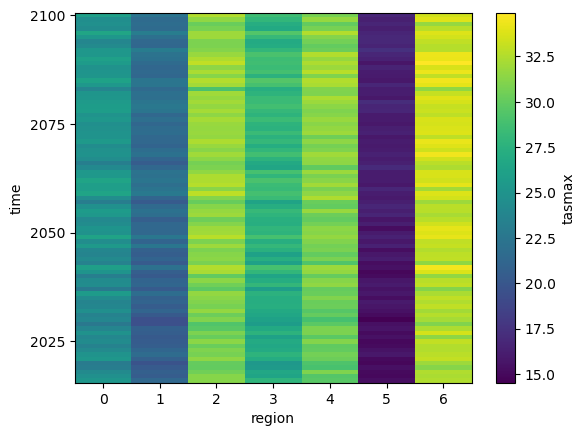

In [22]:
%%time
spatial_means.plot()


In [20]:
%%time
ds = xr.open_mfdataset(filelist,
                      use_cftime = True)

ds = ds["tasmax"]

CPU times: user 1.92 s, sys: 113 ms, total: 2.04 s
Wall time: 2.13 s


In [47]:
%%time
ds_qld = xr.open_mfdataset(filelist,
                      preprocess= lambda ds:ds.where(qld_mask).tasmax,
                      use_cftime = True,
                          chunks={"time":85})

CPU times: user 1.69 s, sys: 75.4 ms, total: 1.77 s
Wall time: 1.77 s


In [ ]:
%%time
ds_qld.load()

In [53]:
%%time
mean_tasmax = ds_qld.mean(dim=["lat", "lon"]).compute()

CPU times: user 7min 42s, sys: 1min 13s, total: 8min 55s
Wall time: 7min 8s


In [54]:
mean_tasmax

<xarray.Dataset> Size: 373kB
Dimensions:  (time: 31046, region: 1)
Coordinates:
  * time     (time) object 248kB 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * region   (region) int64 8B 2
    abbrevs  (region) <U3 12B 'QLD'
    names    (region) <U18 72B 'Queensland'
Data variables:
    tasmax   (time, region) float32 124kB 38.48 39.1 38.9 ... 41.6 40.75 40.2

In [34]:
ds

<xarray.Dataset> Size: 76GB
Dimensions:  (time: 31046, lat: 691, lon: 886)
Coordinates:
  * time     (time) object 248kB 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    tasmax   (time, lat, lon) float32 76GB dask.array<chunksize=(85, 691, 886), meta=np.ndarray>

In [37]:
qld_mask

<xarray.DataArray 'mask' (region: 1, lat: 691, lon: 886)> Size: 612kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * region   (region) int64 8B 2
    abbrevs  (region) <U3 12B 'QLD'
    names    (region) <U18 72B 'Queensland'
Attributes:
    standard_name:  region

In [40]:
gdf_dict["aus_states_territories"]["geometry"].iloc[2]

In [42]:
tasmax_qld

<xarray.Dataset> Size: 76GB
Dimensions:  (time: 31046, lat: 691, lon: 886, region: 1)
Coordinates:
  * time     (time) object 248kB 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * region   (region) int64 8B 2
    abbrevs  (region) <U3 12B 'QLD'
    names    (region) <U18 72B 'Queensland'
Data variables:
    tasmax   (time, lat, lon, region) float32 76GB dask.array<chunksize=(85, 691, 886, 1), meta=np.ndarray>

In [41]:
tasmax_qld = ds.where(qld_mask)

In [ ]:
tasmax_qld_mean = tasmax_qld.mean(dim=["lat", "lon"])

In [ ]:
tasmax_qld_mean
